

---



---

**데이터 병합**

---



---



In [61]:
import pandas as pd
import numpy as np  
import glob  
import sys
import os
import xlrd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

In [ ]:
!pip install xlrd==1.2.0

In [ ]:
# 대기오염물질 데이터 엑셀 병합
file_format = '.xlsx'
file_path = '/content/dataset'
file_list = [f'{file_path}/{file}' for file in os.listdir(file_path) if file_format in file]
merge_df = pd.DataFrame()

for file_name in file_list:
  file_df = pd.read_excel(file_name)
  columns = list(file_df.columns)
  temp_df = pd.DataFrame(file_df, columns=columns)
  merge_df = merge_df.append(temp_df, ignore_index=False)
  merge_df.to_csv('pollution.csv')

In [65]:
# 기상 데이터 엑셀 병합
file_format = '.csv'
file_path = '/content'
file_list = [f'{file_path}/{file}' for file in os.listdir(file_path) if file_format in file]
merge_df = pd.DataFrame()

for file_name in file_list:
  file_df = pd.read_csv(file_name, encoding='cp949')
  columns = list(file_df.columns)
  temp_df = pd.DataFrame(file_df, columns=columns)
  merge_df = merge_df.append(temp_df, ignore_index=False)
  merge_df.to_csv('condition.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



---



---

**EDA**

---



---



In [66]:
df = pd.read_csv('/content/drive/MyDrive/my_data/pollution.csv')

ParserError: ignored

In [ ]:
df1 = df.drop(df.columns[[0]], axis=1)
df1 = df1[df1['지역'].str.contains('서울')]
mask = df1['측정소명'].str.contains('시흥대로')
df1 = df1[~mask]

In [ ]:
df2 = pd.read_csv('/content/condition.csv')

In [ ]:
df2 = df2.drop(df2.columns[[0,1]], axis=1)
df2.shape



---



---

**Feature Engineering**

---



---



In [ ]:
import datetime
df2['일시'] = df2['일시'].astype('str')
df2['일시'] = pd.to_datetime(df2['일시'])
df2['일시'] = df2['일시'] + datetime.timedelta(hours=1)

In [ ]:
from datetime import datetime
df2['일시'] = df2['일시'].apply(lambda _: datetime.strftime(_, '%Y%m%d%H'))

df1['측정일시'] = df1['측정일시'].astype('int')
df2['일시'] = df2['일시'].astype('int')

In [ ]:
df2.rename(columns={'일시':'측정일시'}, inplace=True)

In [ ]:
df1 = df1.dropna()

In [ ]:
df2['강수량(mm)'] = df2['강수량(mm)'].fillna(0)
df2.fillna(method='ffill', inplace=True)
df2.fillna(method='bfill', inplace=True)
drop_col = ['적설(cm)', '3시간신적설(cm)', '운형(운형약어)', '지면상태(지면상태코드)', '현상번호(국내식)', '일사(MJ/m2)', '일조(hr)', '최저운고(100m )']
df2 = df2.drop(columns=drop_col, axis=1)

In [ ]:
df = pd.merge(df1, df2, on='측정일시')

In [ ]:
df['측정일시'] = df['측정일시'].astype('str')
df['측정일시']= df['측정일시'] + '0000'
df['측정일시'] = pd.to_datetime(df['측정일시'])

df['Month'] = df['측정일시'].dt.month
df['Year'] = df['측정일시'].dt.year
df['Hour'] = df['측정일시'].dt.hour
df['Day'] = df['측정일시'].dt.day
df['DayofWeek'] = df['측정일시'].dt.dayofweek

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
df.set_index('측정일시', inplace=True)

In [ ]:
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

In [ ]:
Y_colname = ['PM10']
X_remove = ['지역', '주소', '망', '측정소명']
X_colname = [x for x in df.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df, Y_colname, X_colname, '2020-07-31')



---



---

**LinearRegression**

---



---



In [48]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected = selector.fit_transform(X_train, Y_train)

X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((822851, 10), (300917, 10))

In [49]:
all_names = X_train.columns

selected_mask = selector.get_support()

selected_names = all_names[selected_mask]

unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '증기압(hPa)', '시정(10m)', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')
Unselected names:  Index(['측정소코드', 'O3', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
       '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '전운량(10분위)', '중하층운량(10분위)',
       '지면온도(°C)', 'Month', 'Year', 'Hour', 'Day', 'DayofWeek'],
      dtype='object')


1 features
Selected names:  Index(['PM25'], dtype='object')
Test MAE: $11
Test R2: 0.4511536639884117 

2 features
Selected names:  Index(['CO', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45043722953126686 

3 features
Selected names:  Index(['CO', 'PM25', '시정(10m)'], dtype='object')
Test MAE: $11
Test R2: 0.4546736581897237 

4 features
Selected names:  Index(['CO', 'NO2', 'PM25', '시정(10m)'], dtype='object')
Test MAE: $11
Test R2: 0.4519437696578298 

5 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(10m)'], dtype='object')
Test MAE: $11
Test R2: 0.4431472774410714 

6 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(10m)', '30cm 지중온도(°C)'], dtype='object')
Test MAE: $11
Test R2: 0.4419717180103254 

7 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(10m)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)'],
      dtype='object')
Test MAE: $11
Test R2: 0.4383559511578956 

8 features
Selected names:  Index(['SO2', 'CO', 'NO2', 'PM25', '시정(

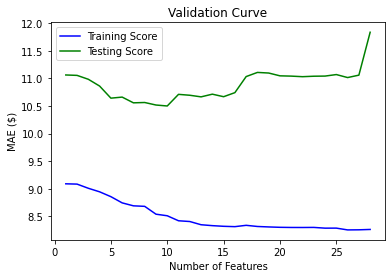

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train.columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, Y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, Y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(Y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

In [ ]:
df.corr().loc[X_colname, X_colname].style.background_gradient().set_precision(2).set_properties(**{'font-size':'11pt'})

,측정소코드,SO2,CO,O3,NO2,PM25,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),전운량(10분위),중하층운량(10분위),시정(10m),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),Month,Year,Hour,Day,DayofWeek
측정소코드,1.00,-0.02,-0.04,0.01,-0.01,0.01,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,0.00,0.00,0.00
SO2,-0.02,1.00,0.33,-0.05,0.34,0.35,-0.14,-0.06,-0.10,0.08,-0.24,-0.21,-0.22,0.20,0.20,-0.10,-0.11,-0.13,-0.11,-0.18,-0.20,-0.21,-0.22,-0.05,-0.36,0.07,0.01,-0.01
CO,-0.04,0.33,1.00,-0.38,0.68,0.58,-0.37,-0.06,-0.28,-0.09,0.03,-0.32,-0.29,0.36,0.36,-0.06,-0.05,-0.35,-0.39,-0.43,-0.43,-0.43,-0.43,-0.07,-0.03,-0.04,-0.00,-0.01
O3,0.01,-0.05,-0.38,1.00,-0.46,-0.04,0.45,-0.02,0.38,0.21,-0.27,0.21,0.25,-0.38,-0.39,-0.01,-0.03,0.09,0.57,0.46,0.39,0.34,0.31,-0.12,0.07,0.22,-0.00,0.06
NO2,-0.01,0.34,0.68,-0.46,1.00,0.47,-0.26,-0.06,-0.32,-0.09,-0.10,-0.30,-0.25,0.32,0.32,-0.05,-0.08,-0.20,-0.30,-0.33,-0.33,-0.34,-0.35,-0.07,-0.06,0.09,0.01,-0.08
PM25,0.01,0.35,0.58,-0.04,0.47,1.00,-0.19,-0.08,-0.14,0.05,0.00,-0.20,-0.15,0.18,0.18,-0.01,-0.02,-0.58,-0.19,-0.26,-0.29,-0.31,-0.33,-0.19,-0.03,0.01,-0.04,0.01
기온(°C),-0.00,-0.14,-0.37,0.45,-0.26,-0.19,1.00,0.06,0.02,-0.10,0.18,0.85,0.90,-0.76,-0.78,0.28,0.18,0.03,0.93,0.97,0.95,0.93,0.91,0.21,-0.03,0.15,0.02,0.01
강수량(mm),-0.00,-0.06,-0.06,-0.02,-0.06,-0.08,0.06,1.00,0.05,-0.04,0.20,0.15,0.12,-0.13,-0.12,0.14,0.15,-0.18,0.04,0.06,0.07,0.08,0.08,0.02,0.01,0.00,-0.01,-0.01
풍속(m/s),0.00,-0.10,-0.28,0.38,-0.32,-0.14,0.02,0.05,1.00,0.28,-0.23,-0.08,-0.09,-0.11,-0.10,-0.01,0.01,0.15,0.13,0.05,-0.01,-0.04,-0.06,-0.11,0.13,0.29,-0.00,-0.01
풍향(16방위),0.00,0.08,-0.09,0.21,-0.09,0.05,-0.10,-0.04,0.28,1.00,-0.23,-0.14,-0.18,0.07,0.07,-0.17,-0.11,0.04,-0.03,-0.06,-0.08,-0.10,-0.12,-0.05,-0.04,0.20,-0.02,-0.03


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                     for i in range(X_train.shape[1])]
vif['Feature'] = X_train.columns
vif.sort_values(by='VIF_Factor', ascending=True)

,VIF_Factor,Feature
7,1.136899e+00,강수량(mm)
27,3.313017e+00,DayofWeek
26,4.238905e+00,Day
16,4.403655e+00,중하층운량(10분위)
9,5.318284e+00,풍향(16방위)
15,6.194343e+00,전운량(10분위)
25,6.586156e+00,Hour
8,6.801028e+00,풍속(m/s)
23,7.747881e+00,Month
3,8.214485e+00,O3


In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values
    return X_colname_vif

In [52]:
X_colname_vif = feature_engineering_XbyVIF(X_train, 11)

In [53]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=10)

X_train_selected = selector.fit_transform(X_train[X_colname_vif], Y_train)

X_test_selected = selector.transform(X_test[X_colname_vif])

X_train_selected.shape, X_test_selected.shape

((822851, 10), (300917, 10))

In [54]:
all_names = X_train[X_colname_vif].columns

selected_mask = selector.get_support()

selected_names = all_names[selected_mask]

unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['강수량(mm)', 'DayofWeek', 'Day', '중하층운량(10분위)', '풍향(16방위)', '전운량(10분위)',
       'Hour', '풍속(m/s)', 'Month', 'PM25'],
      dtype='object')
Unselected names:  Index(['O3'], dtype='object')


1 features
Selected names:  Index(['PM25'], dtype='object')
Test MAE: $11
Test R2: 0.4511536639884117 

2 features
Selected names:  Index(['Month', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45217379630329446 

3 features
Selected names:  Index(['풍향(16방위)', 'Month', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45255422504030196 

4 features
Selected names:  Index(['강수량(mm)', '풍향(16방위)', 'Month', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45240671205362915 

5 features
Selected names:  Index(['강수량(mm)', '중하층운량(10분위)', '풍향(16방위)', 'Month', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45593645338224154 

6 features
Selected names:  Index(['강수량(mm)', '중하층운량(10분위)', '풍향(16방위)', '전운량(10분위)', 'Month', 'PM25'], dtype='object')
Test MAE: $11
Test R2: 0.45675077146682264 

7 features
Selected names:  Index(['강수량(mm)', '중하층운량(10분위)', '풍향(16방위)', '전운량(10분위)', 'Hour', 'Month',
       'PM25'],
      dtype='object')
Test MAE: $11
Test R2: 0.4570884408242756 

8 features
Select

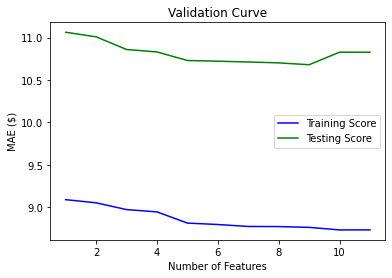

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

training = []
testing = []
ks = range(1, len(X_train[X_colname_vif].columns)+1)

# 1 부터 특성 수 만큼 사용한 모델을 만들어서 MAE 값을 비교 합니다.
for k in range(1, len(X_train[X_colname_vif].columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train[X_colname_vif], Y_train)
    X_test_selected = selector.transform(X_test[X_colname_vif])
    
    all_names = X_train[X_colname_vif].columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, Y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(Y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

In [56]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual

In [57]:
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

In [58]:
fit_reg2 = sm.OLS(Y_train, X_train[X_colname_vif]).fit()
display(fit_reg2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   PM10   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                          7.257e+05
Date:                Fri, 25 Mar 2022   Prob (F-statistic):                        0.00
Time:                        06:02:13   Log-Likelihood:                     -3.4013e+06
No. Observations:              822851   AIC:                                  6.803e+06
Df Residuals:                  822840   BIC:                                  6.803e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
강수량(mm)        -0.5802      0.016    -35.910      0.000      -0.612      -0.549
DayofWeek      -0.1061      0.008    -13.410      0.000      -0.122      -0.091
Day             0.1221      0.002     70.130      0.000       0.119       0.126
중하층운량(10분위)    -0.4347      0.007    -60.568      0.000      -0.449      -0.421
풍향(16방위)        0.0120      0.000     76.982      0.000       0.012       0.012
전운량(10분위)      -0.0444      0.006     -7.067      0.000      -0.057      -0.032
Hour            0.0848      0.003     32.159      0.000       0.080       0.090
풍속(m/s)         2.3377      0.016    142.695      0.000       2.306       2.370
Month           0.1222      0.004     28.022      0.000       0.114       0.131
O3             13.3392      0.983     13.566      0.000      11.412      15.266
PM25            1.3292      0.001   1502.999      0.000       1.327       1.331
==============================================================================
Omnibus:                   851294.231   Durbin-Watson:                   0.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         94304451.477
Skew:                           5.005   Prob(JB):                         0.00
Kurtosis:                      54.482   Cond. No.                     1.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
pred_tr_reg2 = fit_reg2.predict(X_train[X_colname_vif]).values
pred_te_reg2 = fit_reg2.predict(X_test[X_colname_vif]).values

             MAE          MSE       MAPE
Train   8.830239   227.976667  27.972089
Test   10.858464  1084.628085        inf
                         Error
측정일시                          
2020-01-01 01:00:00   2.913066
2020-01-01 01:00:00  16.216633
2020-01-01 01:00:00   5.242293
2020-01-01 01:00:00   4.267953
2020-01-01 01:00:00  12.900746
...                        ...
2017-12-28 15:00:00  19.306217
2017-12-28 15:00:00  21.330858
2017-12-28 15:00:00   8.673424
2017-12-28 15:00:00   0.580050
2017-12-28 15:00:00   2.607747

[822851 rows x 1 columns]
                         Error
측정일시                          
2021-02-01 01:00:00  21.322668
2021-02-01 01:00:00  22.284688
2021-02-01 01:00:00  19.006781
2021-02-01 01:00:00   5.018083
2021-02-01 01:00:00  15.639575
...                        ...
2021-04-30 13:00:00  -7.434384
2021-04-30 13:00:00   1.028235
2021-04-30 13:00:00   0.660009
2021-04-30 13:00:00  -6.919428
2021-04-30 13:00:00   0.716600

[300917 rows x 1 columns]


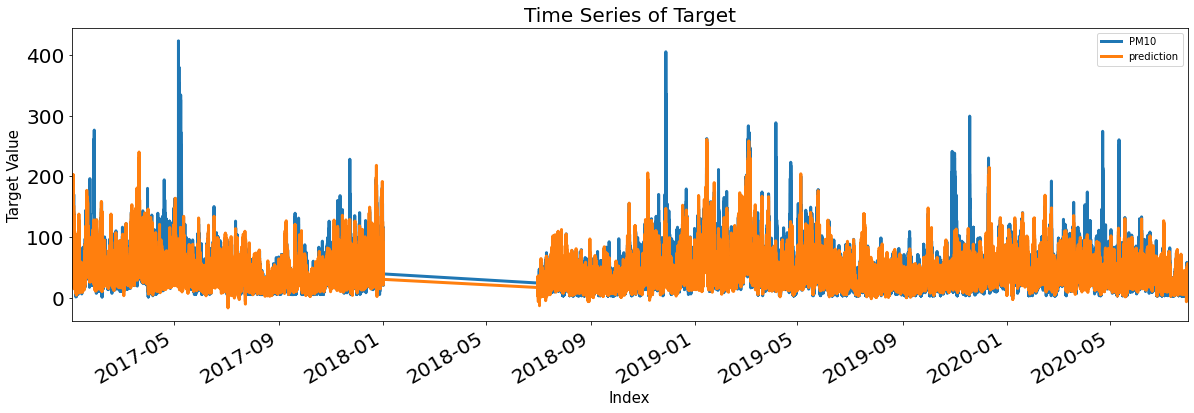

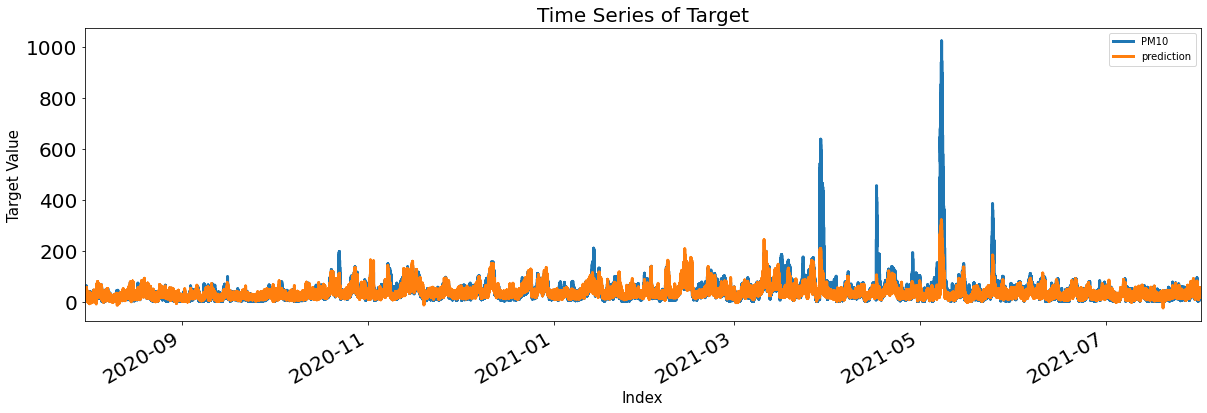

In [60]:
Score_reg2, Resid_tr_reg2, Resid_te_reg2 = evaluation_trte(Y_train, pred_tr_reg2, Y_test, pred_te_reg2, graph_on=True)
print(Score_reg2)
print(Resid_tr_reg2)
print(Resid_te_reg2)